In [1]:
#| default_exp learner

In [2]:
#|export
import math,torch,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from operator import attrgetter
from functools import partial
from copy import copy

from torch import optim
import torch.nn.functional as F

from miniai.conv import *

from fastprogress import progress_bar,master_bar

In [3]:
import matplotlib as mpl
import torchvision.transforms.functional as TF
from contextlib import contextmanager
from torch import nn,tensor
from datasets import load_dataset,load_dataset_builder
from miniai.datasets import *
from miniai.conv import *
import logging
from fastcore.test import test_close

In [4]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

In [5]:
logging.disable(logging.WARNING)

## Learner

In [6]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [8]:
bs = 1024
tds = dsd.with_transform(transformi)

In [11]:
DataLoaders.from_dd??

Signature: DataLoaders.from_dd(dd, batch_size, as_tuple=True, **kwargs)
Docstring: <no docstring>
Source:   
    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls(*dd.values(), bs=batch_size, collate_fn=f, **kwargs))
File:      /notebooks/miniai/datasets.py
Type:      method


In [12]:
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 784]), tensor([0, 8, 4, 9, 5, 9, 4, 4, 7, 8]))

In [13]:
# def_device is set at conv.py
to_device??

Signature: to_device(x, device='cuda')
Docstring: <no docstring>
Source:   
def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)
File:      /notebooks/miniai/conv.py
Type:      function


In [14]:
def_device??

Type:        str
String form: cuda
Length:      4
Docstring:  
str(object='') -> str
str(bytes_or_buffer[, encoding[, errors]]) -> str

Create a new string object from the given object. If encoding or
errors is specified, then the object must expose a data buffer
that will be decoded using the given encoding and error handler.
Otherwise, returns the result of object.__str__() (if defined)
or repr(object).
encoding defaults to sys.getdefaultencoding().
errors defaults to 'strict'.


In [15]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD): fc.store_attr()

    def one_batch(self):
        # import pdb; pdb.set_trace()
        self.xb,self.yb = to_device(self.batch)
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad(): self.calc_stats()

    def calc_stats(self):
        acc = (self.preds.argmax(dim=1)==self.yb).float().sum()
        self.accs.append(acc)
        n = len(self.xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)

    def one_epoch(self, train):
        self.model.training = train
        dl = self.dls.train if train else self.dls.valid
        for self.num,self.batch in enumerate(dl): self.one_batch()
        n = sum(self.ns)
        print(self.epoch, self.model.training, sum(self.losses).item()/n, sum(self.accs).item()/n)
    
    def fit(self, n_epochs):
        self.accs,self.losses,self.ns = [],[],[]
        self.model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epochs
        for self.epoch in range(n_epochs):
            self.one_epoch(True) # train
            with torch.no_grad(): self.one_epoch(False) # eval

In [16]:
m,nh = 28*28,50
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [17]:
learn = Learner(model, dls, F.cross_entropy, lr=0.2)

In [18]:
# learn.fit(7)

## Basic Callbacks Learner

In [19]:
#|export
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

In [20]:
#|export
class Callback(): order = 0

In [21]:
#|export
def run_cbs(cbs, method_nm, learn=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None: method(learn)

In [22]:
class CompletionCB(Callback):
    def before_fit(self, learn): self.count = 0
    def after_batch(self, learn): self.count += 1
    def after_fit(self, learn): print(f'Completed {self.count} batches')

In [24]:
cbs = [CompletionCB()]
run_cbs(cbs, 'before_fit')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_fit')

Completed 1 batches


In [25]:
cb = cbs[0]
for _ in range(10): cb.after_batch(learn=None)
cb.after_fit(None)

Completed 11 batches


In [29]:
class Learner():
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD): fc.store_attr()

    def one_batch(self):
        self.preds = self.model(self.batch[0])
        self.loss = self.loss_func(self.preds, self.batch[1])
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()

    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        try:
            self.callback('before_epoch')
            for self.iter,self.batch in enumerate(self.dl):
                try:
                    self.callback('before_batch')
                    self.one_batch()
                    self.callback('after_batch')
                except CancelBatchException: pass
            self.callback('after_epoch')
        except CancelEpochException: pass
    
    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        try:
            self.callback('before_fit')
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
            self.callback('after_fit')
        except CancelFitException: pass

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)

In [30]:
m,nh = 28*28,50
def get_model(): return nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [31]:
model = get_model()
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[CompletionCB()])
learn.fit(1)

Completed 0 batches


In [59]:
#| export
class SingleBatchCB(Callback):
    order = 1
    def after_batch(self, learn): raise CancelEpochException()

In [52]:
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=[SingleBatchCB(), CompletionCB()])
learn.fit(1)

Completed 2 batches


## Metrics

In [53]:
class Metric:
    def __init__(self): self.reset()
    def reset(self): self.vals,self.ns = [],[]
    def add(self, inp, targ=None, n=1):
        self.last = self.calc(inp, targ)
        self.vals.append(self.last)
        self.ns.append(n)
    @property
    def value(self):
        ns = tensor(self.ns)
        return (tensor(self.vals)*ns).sum()/ns.sum()
    def calc(self, inps, targs): return inps

In [54]:
class Accuracy(Metric):
    def calc(self, inps, targs): return (inps==targs).float().mean()

In [55]:
acc = Accuracy()
acc.add(tensor([0, 1, 2, 0, 1, 2]), tensor([0, 1, 1, 2, 1, 0]))
acc.add(tensor([1, 1, 2, 0, 1]), tensor([0, 1, 1, 2, 1]))
acc.value

tensor(0.45)

In [56]:
loss = Metric()
loss.add(0.6, n=32)
loss.add(0.9, n=2)
loss.value, round((0.6*32+0.9*2)/(32+2), 2)

(tensor(0.62), 0.62)

## Some callbacks

In [57]:
pip install torcheval

Note: you may need to restart the kernel to use updated packages.


In [68]:
#|export
from torcheval.metrics import MulticlassAccuracy,Mean

In [69]:
metric = MulticlassAccuracy()
metric.update(tensor([0, 2, 1, 3]), tensor([0, 1, 2, 3]))
metric.compute()

tensor(0.50)

In [70]:
metric.reset()
metric.compute()

tensor(nan)

In [71]:
#|export
def to_cpu(x):
    if isinstance(x, Mapping): return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): return [to_cpu(o) for o in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    res = x.detach().cpu()
    return res.float() if res.dtype==torch.float16 else res

In [72]:
#|export
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o # convinience so name or class names can be passed
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean() # convinience added loss weighted average of the losses

    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

In [73]:
#|export
class DeviceCB(Callback):
    def __init__(self, device=def_device): fc.store_attr()
    def before_fit(self, learn):
        if hasattr(learn.model, 'to'): learn.model.to(self.device)
    def before_batch(self, learn): learn.batch = to_device(learn.batch, device=self.device)

In [74]:
model = get_model()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(), metrics])
learn.fit(1)

{'accuracy': '0.595', 'loss': '1.193', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.713', 'loss': '0.788', 'epoch': 0, 'train': 'eval'}


## Flexible learner

In [76]:
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()

    @contextmanager
    def cb_ctx(self, nm):
        try: # in a cm up to yield is called before your code
            self.callback(f'before_{nm}') 
            yield # in a cm it enters the for loop
            self.callback(f'after_{nm}') # in a cm after the loop
        except globals()[f'Cancel{nm.title()}Exception']: pass
        finally: self.callback(f'cleanup_{nm}')
                
    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        with self.cb_ctx('epoch'):
            for self.iter,self.batch in enumerate(self.dl):
                with self.cb_ctx('batch'):
                    self.predict()
                    self.get_loss()
                    if self.training:
                        self.backward()
                        self.step()
                        self.zero_grad()
    
    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            self.opt = self.opt_func(self.model.parameters(), self.lr if lr is None else lr)
            with self.cb_ctx('fit'):
                for self.epoch in self.epochs:
                    if train: self.one_epoch(True)
                    if valid: torch.no_grad()(self.one_epoch)(False)
                    # torch.no_grad is a ctx mnag, its equivalent to: with torch.no_grad(): self.one_epoch(False)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training

In [77]:
#|export
class TrainCB(Callback):
    def __init__(self, n_inp=1): self.n_inp = n_inp
    def predict(self, learn): learn.preds = learn.model(*learn.batch[:self.n_inp])
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

NB: I added `self.n_inp` after the lesson. This allows us to train models with more than one input or output.

In [81]:
#|export
class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []
        self.val_losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses: self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])
    
    def after_epoch(self, learn): 
        if not learn.training:
            if self.plot and hasattr(learn, 'metrics'): 
                self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch+1).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])

NB: Added validation loss plotting after the lesson.

In [82]:
model = get_model()

accuracy,loss,epoch,train
0.605,1.178,0,train
0.693,0.840,0,eval
0.745,0.713,1,train
0.766,0.659,1,eval


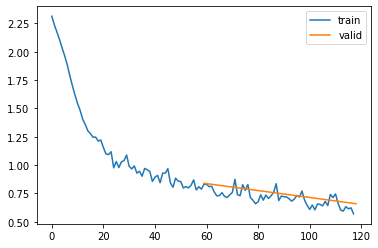

In [83]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(2)

## Updated versions since the lesson

After the lesson we noticed that `contextlib.context_manager` has a surprising "feature" which doesn't let us raise an exception before the `yield`. Therefore we've replaced the context manager with a decorator in this updated version of `Learner`. We have also added a few more callbacks in `one_epoch()`.

In [84]:
#|export
class with_cbs:
    def __init__(self, nm): self.nm = nm
    def __call__(self, f):
        def _f(o, *args, **kwargs):
            try:
                o.callback(f'before_{self.nm}')
                f(o, *args, **kwargs)
                o.callback(f'after_{self.nm}')
            except globals()[f'Cancel{self.nm.title()}Exception']: pass
            finally: o.callback(f'cleanup_{self.nm}')
        return _f

In [93]:
#|export
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()

    @with_cbs('batch')
    def _one_batch(self):
        # import pdb; pdb.set_trace()
        self.predict()
        self.callback('after_predict')
        self.get_loss()
        self.callback('after_loss')
        if self.training:
            self.backward()
            self.callback('after_backward')
            self.step()
            self.callback('after_step')
            self.zero_grad()

    @with_cbs('epoch')
    def _one_epoch(self):
        for self.iter,self.batch in enumerate(self.dl): self._one_batch()

    def one_epoch(self, training):
        self.model.train(training)
        self.dl = self.dls.train if training else self.dls.valid
        self._one_epoch()

    @with_cbs('fit')
    def _fit(self, train, valid):
        for self.epoch in self.epochs:
            if train: self.one_epoch(True)
            if valid: torch.no_grad()(self.one_epoch)(False)

    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            if lr is None: lr = self.lr
            if self.opt_func: self.opt = self.opt_func(self.model.parameters(), lr)
            self._fit(train, valid)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training

accuracy,loss,epoch,train
0.600,1.174,0,train
0.680,0.814,0,eval


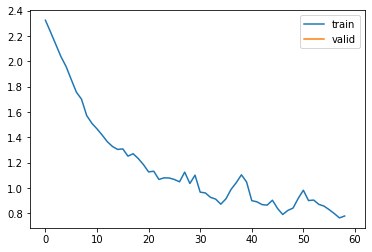

In [94]:
model = get_model()

metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

## TrainLearner and MomentumLearner

In [100]:
#|export
class TrainLearner(Learner):
    def predict(self): self.preds = self.model(self.batch[0])
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

In [101]:
#|export
class MomentumLearner(TrainLearner):
    def __init__(self, model, dls, loss_func, lr=None, cbs=None, opt_func=optim.SGD, mom=0.85):
        self.mom = mom
        super().__init__(model, dls, loss_func, lr, cbs, opt_func)

    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters(): p.grad *= self.mom

accuracy,loss,epoch,train
0.682,0.915,0,train
0.797,0.578,0,eval


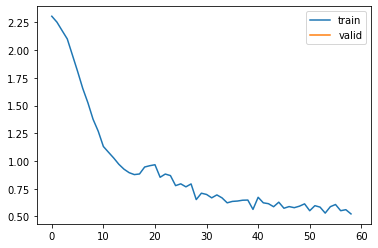

In [97]:
# NB: No TrainCB
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.1, cbs=cbs)
learn.fit(1)

## LRFinderCB

In [102]:
class LRFinderCB(Callback):
    def __init__(self, lr_mult=1.3): fc.store_attr()
    
    def before_fit(self, learn):
        self.lrs,self.losses = [],[]
        self.min = math.inf

    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException() # eg of using excep as a control struct
        self.lrs.append(learn.opt.param_groups[0]['lr']) # lr are stored in pt in this loc, dont worry too much
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if loss > self.min*3: raise CancelFitException() # stop training
        for g in learn.opt.param_groups: g['lr'] *= self.lr_mult # again in pt this is how the lr is updated

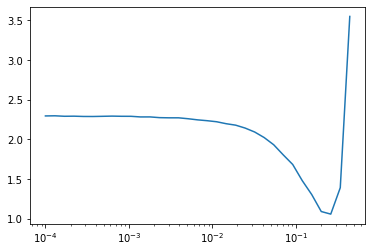

In [103]:
lrfind = LRFinderCB() # this cb needs instantiation first so to grab its lr and losses
cbs = [DeviceCB(), lrfind]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-4, cbs=cbs)
learn.fit(1)
plt.plot(lrfind.lrs, lrfind.losses)
plt.xscale('log')

In [104]:
#|export
from torch.optim.lr_scheduler import ExponentialLR

[ExponentialLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html#torch.optim.lr_scheduler.ExponentialLR)

In [105]:
#|export
class LRFinderCB(Callback):
    def __init__(self, gamma=1.3, max_mult=3): fc.store_attr()
    
    def before_fit(self, learn):
        self.sched = ExponentialLR(learn.opt, self.gamma)
        self.lrs,self.losses = [],[]
        self.min = math.inf

    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if math.isnan(loss) or (loss > self.min*self.max_mult):
            raise CancelFitException()
        self.sched.step()

    def cleanup_fit(self, learn):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

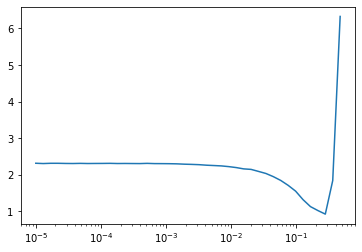

In [106]:
cbs = [DeviceCB()]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-5, cbs=cbs)
learn.fit(3, cbs=LRFinderCB())

In [113]:
#|export
@fc.patch
def lr_find(self:Learner, gamma=1.3, max_mult=3, start_lr=1e-5, max_epochs=10):
    self.fit(max_epochs, lr=start_lr, cbs=LRFinderCB(gamma=gamma, max_mult=max_mult))

`lr_find` was added in lesson 18. It's just a shorter way of using `LRFinderCB`.

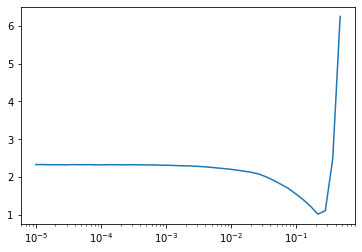

In [108]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=cbs).lr_find()

In [111]:
dls??

Type:        DataLoaders
String form: <miniai.datasets.DataLoaders object at 0x7f11e3f971c0>
File:        /notebooks/miniai/datasets.py
Source:     
class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls[:2]

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls(*dd.values(), bs=batch_size, collate_fn=f, **kwargs))


In [109]:
get_model??

Signature: get_model()
Docstring: <no docstring>
Source:    def get_model(): return nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
File:      /tmp/ipykernel_1726/3492880619.py
Type:      function


## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()

/home/tmabraham/anaconda3/envs/course22p2/lib/python3.10/site-packages/nbdev/export.py:54: UserWarning: Notebook '/home/tmabraham/course22p2/nbs/horse2zebra-latents_AB.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"
/home/tmabraham/anaconda3/envs/course22p2/lib/python3.10/site-packages/nbdev/export.py:54: UserWarning: Notebook '/home/tmabraham/course22p2/nbs/FIBItoHE-latents_AB.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"
